<a href="https://colab.research.google.com/github/Winkielek/gflownet/blob/master/notebooks/actions_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

### Action classifier

In [18]:
df = pd.read_csv("/content/featurized_mols_actions_1000.csv", index_col=0)

In [19]:
# Exclude stop action
df = df[df.target != "stop"]

In [20]:
# Class balance
df['target'].value_counts()

set_edge_attr    4309
add_node         2325
Name: target, dtype: int64

In [21]:
X, y = df[[col for col in df.columns if col != "target"]], df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Try models with default params

In [22]:
rf = RandomForestClassifier()

# Fit the random search model
rf.fit(X_train, y_train)

RandomForestClassifier()

In [23]:
rf.score(X_test, y_test)

0.7407686510926903

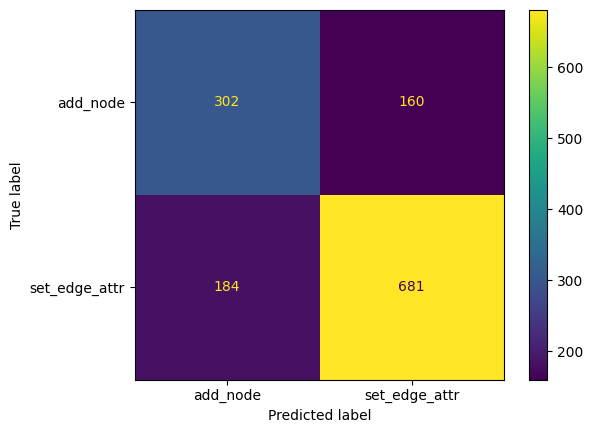

In [24]:
# Confusion matrix on test data
predictions = rf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

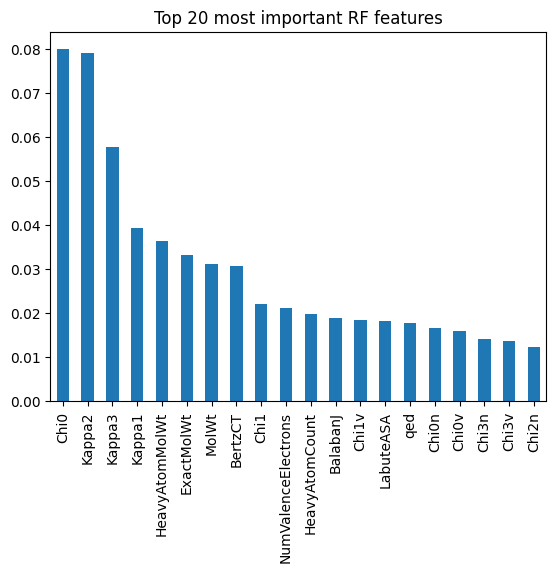

In [25]:
# Features importance
sort_perm = np.argsort(rf.feature_importances_)
most_important = rf.feature_importances_[sort_perm][::-1]
most_important_names = rf.feature_names_in_[sort_perm][::-1]
forest_importances = pd.Series(most_important[:20], index=most_important_names[:20])
forest_importances.plot.bar()
plt.title('Top 20 most important RF features')
plt.show()

Simple decision trees

In [26]:
for depth in range(2, 6):
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)
    sc = tree.score(X_test, y_test)
    print(f"Tree depth {depth}: accuracy {round(sc, 3)}")

Tree depth 2: accuracy 0.841
Tree depth 3: accuracy 0.846
Tree depth 4: accuracy 0.845
Tree depth 5: accuracy 0.843


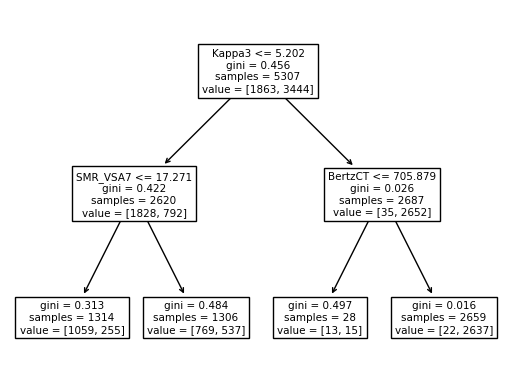

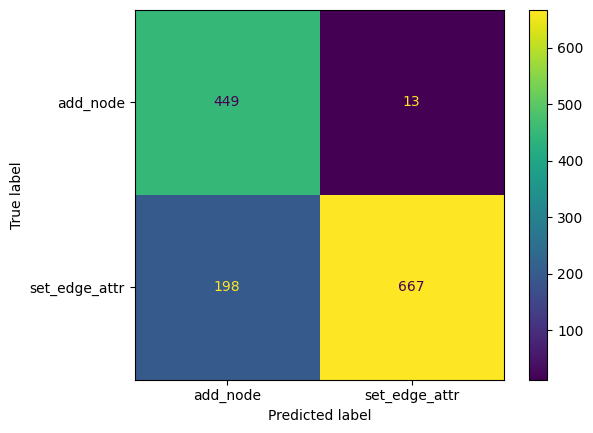

In [27]:
tree_2 = DecisionTreeClassifier(max_depth=2)
tree_2.fit(X_train, y_train)
plot_tree(tree_2, feature_names=tree_2.feature_names_in_)
plt.show()
predictions = tree_2.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

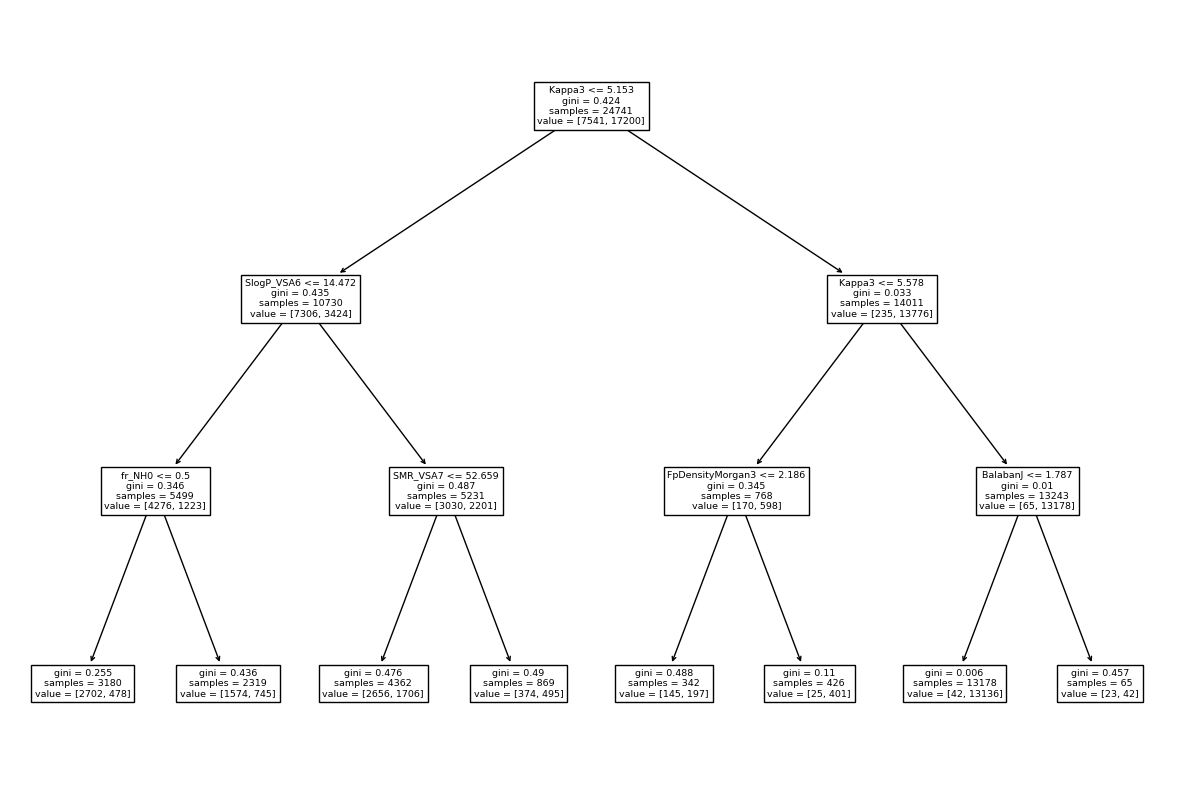

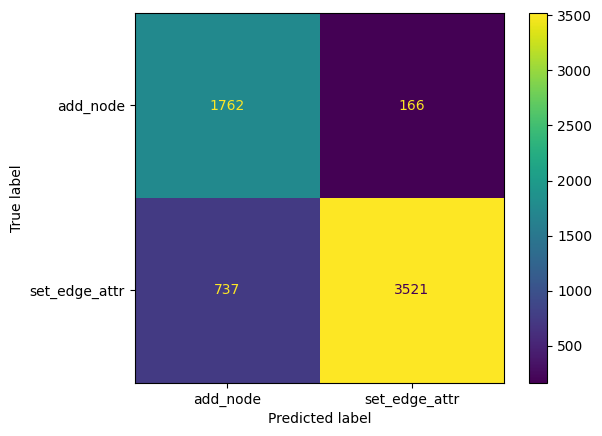

In [12]:
tree_3 = DecisionTreeClassifier(max_depth=3)
tree_3.fit(X_train, y_train)
plt.figure(figsize=(15, 10))
plot_tree(tree_3, feature_names=tree_3.feature_names_in_)
plt.show()
predictions = tree_3.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

### Variable selection with LASSO

In [13]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

In [14]:
# parameters to be tested on GridSearchCV
lasso = Lasso(max_iter=10000, alpha=0.5)
lb = LabelBinarizer()
# GridSearchCV with model, params and folds.
lasso.fit(X_train, lb.fit_transform(y_train))

Lasso(alpha=0.5, max_iter=10000)

<Axes: >

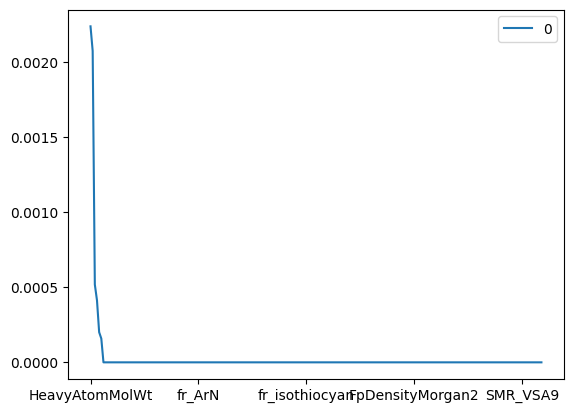

In [15]:
lasso_coef = np.abs(lasso.coef_)
df_coef = pd.DataFrame(lasso_coef, lasso.feature_names_in_).sort_values(by=0, ascending=False)
df_coef.plot()

In [16]:
selected = df_coef.index[df_coef.iloc[:, 0]>0].values
selected

array(['HeavyAtomMolWt', 'SMR_VSA7', 'EState_VSA5', 'PEOE_VSA6',
       'BertzCT', 'SMR_VSA5'], dtype=object)

In [17]:
rf_2 = RandomForestClassifier()
rf_2.fit(X_train[selected], y_train)
rf_2.score(X_test[selected], y_test)

0.7681862269641125

In [ ]:
rf_2 = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf_2, param_distributions = random_grid, n_iter = 25, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(X_train[selected], y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.score(X_test[selected], y_test)

0.813112283345893